In [234]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from statistics import mean
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import tensorflow as tf
import os

%matplotlib notebook

In [235]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
#Read the output csv files of DataCleaning.ipynb which are saved in Google drive 
cpi_df = pd.read_csv("/content/drive/MyDrive/Data/cpi_all_data.csv")
wpi_df = pd.read_csv("/content/drive/MyDrive/Data/wpi_all_data.csv")


In [243]:
#Look in CPI data frame
cpi_df.tail()

,Qtr,Sydney,Melbourne,Brisbane,Adelaide,Perth,Hobart,Darwin,Canberra,Australia
96,2022-03-01,1.7,2.3,2.2,1.9,3.3,2.0,2.1,2.2,2.1
97,2022-06-01,1.6,1.8,2.1,2.1,1.7,1.8,2.1,1.6,1.8
98,2022-09-01,2.3,2.1,1.8,2.6,-0.5,2.3,1.9,1.9,1.8
99,2022-12-01,1.8,1.6,1.5,1.7,3.6,1.5,0.9,1.2,1.9
100,2023-03-01,1.4,1.2,1.9,1.2,0.9,1.2,1.3,1.4,1.4


In [244]:
#Drop the last row in the CPI data table just to make the number of CPI data and WPI data records equal.
cpi_df = cpi_df.drop(labels = 100 , axis = 0)

#Drop the columns that contain CPI for differnt cities
cpi_df = cpi_df.drop(cpi_df.iloc[:,1:9], axis = 1)

#Rename the 'Australia' column
cpi_df = cpi_df.rename(columns = {'Australia' : 'CPI_percentage_change'})

cpi_df.tail()

,Qtr,CPI_percentage_change
95,2021-12-01,1.3
96,2022-03-01,2.1
97,2022-06-01,1.8
98,2022-09-01,1.8
99,2022-12-01,1.9


In [245]:
# Look in WPI data frame
wpi_df.tail()

,Qtr,WPI_percentage_change
95,2021-12-01,0.7
96,2022-03-01,0.7
97,2022-06-01,0.8
98,2022-09-01,1.1
99,2022-12-01,0.8


In [246]:
# Merge two data sets into one data frame
combined_df = pd.merge(wpi_df,cpi_df,on = "Qtr")
combined_df.head(5)

,Qtr,WPI_percentage_change,CPI_percentage_change
0,1998-03-01,0.9,0.3
1,1998-06-01,0.7,0.6
2,1998-09-01,0.7,0.1
3,1998-12-01,0.7,0.4
4,1999-03-01,0.9,0.0


In [247]:
#Check the data types
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Qtr                    100 non-null    object 
 1   WPI_percentage_change  100 non-null    float64
 2   CPI_percentage_change  100 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [248]:
#Change the format of 'Qtr' column
combined_df['Qtr'] = pd.to_datetime(combined_df['Qtr'],infer_datetime_format = True)

In [249]:
#Make sure the type of 'Qtr' column is datetime
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Qtr                    100 non-null    datetime64[ns]
 1   WPI_percentage_change  100 non-null    float64       
 2   CPI_percentage_change  100 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.1 KB


In [250]:
# Set the 'Qtr' column as the index
combined_df.set_index("Qtr", inplace = True)
combined_df.head()

,WPI_percentage_change,CPI_percentage_change
Qtr,,
1998-03-01,0.9,0.3
1998-06-01,0.7,0.6
1998-09-01,0.7,0.1
1998-12-01,0.7,0.4
1999-03-01,0.9,0.0


<Axes: xlabel='Qtr'>

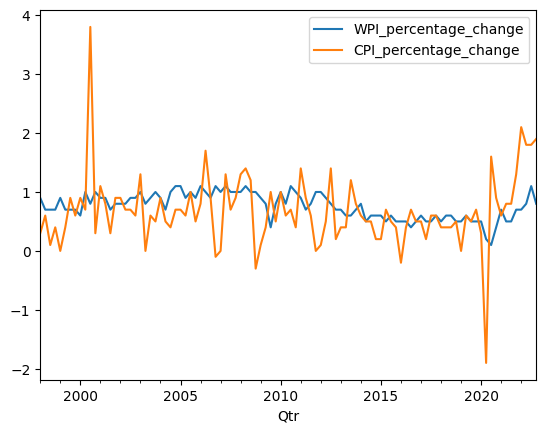

In [251]:
#Plot two time series in one graph
%matplotlib inline
combined_df.plot()


In [252]:
#Create a copy of combined data frame
df_input = combined_df[['WPI_percentage_change','CPI_percentage_change']]

#Check the main statistics of data to get an idea of data distrbution and about any outliers
df_input.describe()

,WPI_percentage_change,CPI_percentage_change
count,100.000000,100.000000
mean,0.760000,0.675000
std,0.219734,0.615355
min,0.100000,-1.900000
25%,0.600000,0.400000
50%,0.800000,0.600000
75%,0.925000,0.900000
max,1.100000,3.800000


In [253]:
#Check the created copy of data frame
df_input

,WPI_percentage_change,CPI_percentage_change
Qtr,,
1998-03-01,0.9,0.3
1998-06-01,0.7,0.6
1998-09-01,0.7,0.1
1998-12-01,0.7,0.4
1999-03-01,0.9,0.0
...,...,...
2021-12-01,0.7,1.3
2022-03-01,0.7,2.1
2022-06-01,0.8,1.8


In [254]:
# Create a function to define target and features
# Use two previous data records to predict the third record - for example use t1 and t2 to predict t3, use t2 and t3 to predict t4, t3 and t4 to predict t4 and so on

def df_to_X_y(df, window_size=2):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [255]:
#check the X and y shape
X, y = df_to_X_y(df_input)
X.shape, y.shape

((98, 2, 2), (98,))

In [256]:
# Split data into train, validation and test parts
X_train, y_train = X[:75], y[:75]
X_val, y_val = X[75:83], y[75:83]
X_test, y_test = X[83:], y[83:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((75, 2, 2), (75,), (8, 2, 2), (8,), (15, 2, 2), (15,))

In [258]:
#define mean and standard deviation to Standardize WPI percentage change data column
wpi_training_mean = np.mean(X_train[:,:,0])
wpi_training_std = np.std(X_train[:,:,0])

#Define a function to standardise WPI percentage change data column
def preprocess(X):
  X[:,:,0] = (X[:,:,0] - wpi_training_mean) / wpi_training_std
  return X


In [259]:
# Standardize X data set
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)

array([[[-1.73456419,  0.5       ],
        [-1.73456419,  0.        ]],

       [[-1.73456419,  0.        ],
        [-1.19920487,  0.6       ]],

       [[-1.19920487,  0.6       ],
        [-1.73456419,  0.5       ]],

       [[-1.73456419,  0.5       ],
        [-1.73456419,  0.7       ]],

       [[-1.73456419,  0.7       ],
        [-1.73456419,  0.3       ]],

       [[-1.73456419,  0.3       ],
        [-3.34064215, -1.9       ]],

       [[-3.34064215, -1.9       ],
        [-3.87600146,  1.6       ]],

       [[-3.87600146,  1.6       ],
        [-2.26992351,  0.9       ]],

       [[-2.26992351,  0.9       ],
        [-0.66384555,  0.6       ]],

       [[-0.66384555,  0.6       ],
        [-1.73456419,  0.8       ]],

       [[-1.73456419,  0.8       ],
        [-1.73456419,  0.8       ]],

       [[-1.73456419,  0.8       ],
        [-0.66384555,  1.3       ]],

       [[-0.66384555,  1.3       ],
        [-0.66384555,  2.1       ]],

       [[-0.66384555,  2.1       ],
  

In [260]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

#Define LSTM model
model = Sequential()
model.add(InputLayer((2,2)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 64)                17152     
                                                                 
 dense_27 (Dense)            (None, 8)                 520       
                                                                 
 dense_28 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


In [261]:
model.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])

In [262]:
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 50, shuffle = False)

Epoch 1/50
3/3 [==============================] - 5s 429ms/step - loss: 0.6809 - root_mean_squared_error: 0.8252 - val_loss: 0.2942 - val_root_mean_squared_error: 0.5424
Epoch 2/50
3/3 [==============================] - 0s 34ms/step - loss: 0.6418 - root_mean_squared_error: 0.8011 - val_loss: 0.2693 - val_root_mean_squared_error: 0.5189
Epoch 3/50
3/3 [==============================] - 0s 28ms/step - loss: 0.6106 - root_mean_squared_error: 0.7814 - val_loss: 0.2592 - val_root_mean_squared_error: 0.5091
Epoch 4/50
3/3 [==============================] - 0s 28ms/step - loss: 0.5783 - root_mean_squared_error: 0.7605 - val_loss: 0.2480 - val_root_mean_squared_error: 0.4980
Epoch 5/50
3/3 [==============================] - 0s 28ms/step - loss: 0.5452 - root_mean_squared_error: 0.7383 - val_loss: 0.2371 - val_root_mean_squared_error: 0.4869
Epoch 6/50
3/3 [==============================] - 0s 33ms/step - loss: 0.5112 - root_mean_squared_error: 0.7150 - val_loss: 0.2260 - val_root_mean_squared

In [267]:
from sklearn.metrics import mean_squared_error as mse

#Define a function to generate a dataframe and plots of predictions and actuals

def plot_predictions(model, X, y, start =0, end =97):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data = {'Predictions': predictions, 'Actuals': y})
  plt.plot(df['Predictions'][start:end], label = "Predictions")
  plt.plot(df['Actuals'][start:end], label = "Actuals")
  return df, mse(y, predictions)

3/3 [==============================] - 0s 4ms/step


(    Predictions  Actuals
 0      0.660551      0.7
 1      0.600368      0.7
 2      0.535630      0.9
 3      0.607843      0.7
 4      0.570993      0.7
 ..          ...      ...
 70     0.574996      0.5
 71     0.505045      0.5
 72     0.502958      0.4
 73     0.593230      0.5
 74     0.640616      0.6
 
 [75 rows x 2 columns],
 0.026932383959371073)

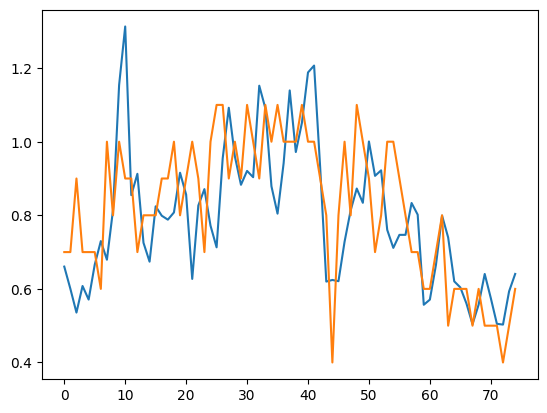

In [269]:
# See how the model works for training data set

plot_predictions(model,X_train, y_train)

1/1 [==============================] - 0s 77ms/step


(   Predictions  Actuals
 0     0.603964      0.5
 1     0.549958      0.5
 2     0.552439      0.6
 3     0.634854      0.5
 4     0.593266      0.6
 5     0.572932      0.6
 6     0.566848      0.5
 7     0.569101      0.5,
 0.005471704615215813)

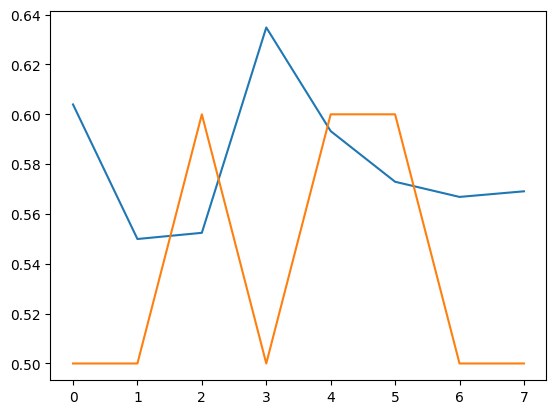

In [271]:
# See how the model works for validating data set

plot_predictions(model, X_val, y_val)

1/1 [==============================] - 0s 30ms/step


(    Predictions  Actuals
 0      0.531296      0.6
 1      0.523660      0.5
 2      0.605729      0.5
 3      0.619200      0.5
 4      0.605018      0.2
 5      0.513702      0.1
 6      0.727711      0.4
 7      0.862381      0.7
 8      0.709919      0.5
 9      0.641174      0.5
 10     0.685070      0.7
 11     0.774095      0.7
 12     0.999651      0.8
 13     1.141626      1.1
 14     1.178552      0.8,
 0.05028149651357784)

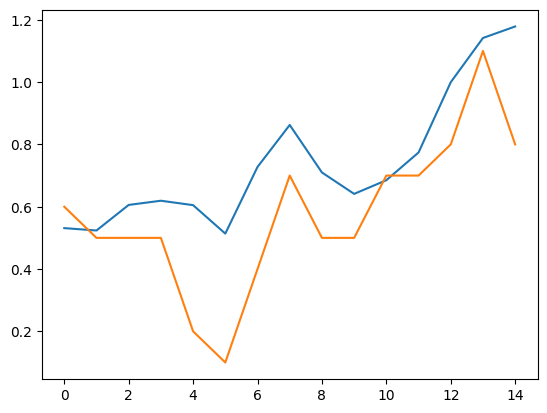

In [272]:
# See how the model works for test data set

plot_predictions(model, X_test, y_test)